In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import ast
from google.colab import drive
import random
from PIL import Image
import json
from scipy.spatial import distance


drive.mount('/content/drive')
base_folder = '/content/drive/MyDrive/ucph/CCS3'

Mounted at /content/drive


In [ ]:
def read_point_dictionariy(file_path):

  # Path to the JSON file
  file_path = os.path.join(base_folder, file_path)

  # Read the dictionary from the JSON file
  with open(file_path, "r") as file:
      points_dict = json.load(file)
  return points_dict

def convert_dict_to_list(dict_to_change):
  new_dict = {}
  for key, value in dict_to_change.items():
    if isinstance(value, dict):
      new_dict[key] = list(value['points'])
  return new_dict

def get_random_ex(point_dict):
  # Get a random sample
  random_key = random.choice(list(point_dict.keys()))  # Pick a random key
  random_sample = point_dict[random_key]

  # Output the random sample
  print(f"Random Key: {type(random_key)} {random_key}")
  print(f"Random Sample: {type(random_sample)} {random_sample}")
  print(f"Length of Dictionary: {len(point_dict.keys())}")


def load_image_mask(image_filename, parent_folder='segmentations'):
  image_path = os.path.join(base_folder, 'images', image_filename)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image_array = np.array(img)
  mask_filename = '_'.join(image_filename.split('_')[1:])
  mask_filename = mask_filename.replace('jpg', 'png')
  mask_path = os.path.join(base_folder, parent_folder, mask_filename)
  mask = cv2.imread(mask_path)
  #mask = Image.open(mask_path).convert("RGB")
  mask_array = np.array(mask)

  return image_array, mask_array

def filter_numeric(values):
    values = [x for x in values if x is not None and not np.isnan(x)]
    return [x for x in values if isinstance(x, (int, float))]

def calc_acc(df):
  # Res_Net points
  all_res_mean = np.mean(filter_numeric(df['res'].tolist()))
  all_res_std = np.std(filter_numeric(df['res'].tolist()))

  # Fixation points
  all_fix_mean = np.mean(filter_numeric(df['fix'].tolist()))
  all_fix_std = np.std(filter_numeric(df['fix'].tolist()))

  # Faster points
  all_faster_mean = np.mean(filter_numeric(df['faster'].tolist()))
  all_faster_std = np.std(filter_numeric(df['faster'].tolist()))

  row = [all_res_mean, all_res_std, all_faster_mean, all_faster_std, all_fix_mean, all_fix_std]

  # best model points
  best_res = np.mean(filter_numeric(df['res_best'].tolist()))
  best_faster = np.mean(filter_numeric(df['faster_best'].tolist()))

  row = row + [best_res, best_faster]

  # V1 - V5 Fixation points
  for v in range(1, 6):
      col = f"v{v}_fix"
      numeric_values = filter_numeric(df[col].tolist())
      row.append(np.mean(numeric_values))
      row.append(np.std(numeric_values))

  return row


def print_res(df):
    # Define column headers
    headers = [
        "Split", "Length", "GradCAM", "GradCAM_std", "Ablation", "Ablation_std",
        "Fix_Mean", "Fix_Std", "GradCAM_Best", "Ablation_Best",
        "V1_Fix_Mean", "V1_Fix_Std",
        "V2_Fix_Mean", "V2_Fix_Std",
        "V3_Fix_Mean", "V3_Fix_Std",
        "V4_Fix_Mean", "V4_Fix_Std",
        "V5_Fix_Mean", "V5_Fix_Std"
    ]

    # Print header row
    print("\t".join(headers))
    print("-" * 120)

    # Helper function to format and round row values
    def format_row(label, length, values):
        # Round numeric values to 2 decimals and convert to strings
        rounded_values = [f"{x:.3f}" for x in values]
        # Combine label, length, and values with tabs
        return f"{label}\t{length}\t" + "\t".join(rounded_values)

    # Calculate and print the results for the full dataset
    row = calc_acc(df)
    print(format_row("All", len(df), row))

    # Process and print results for each class
    classes = list(set(filename.split('_')[0] for filename in os.listdir(os.path.join(base_folder, 'images'))))
    for object_class in classes:
        class_df = df[df['class'] == object_class]
        row = calc_acc(class_df)
        print(format_row(object_class, len(class_df), row))

def show_histo(values, title):
  # Define bins for each unique integer
  min_value = min(values)
  max_value = max(values)
  print(min_value, max_value)
  bins = range(min_value, max_value + 2)  # One bin per integer

  # Plot the histogram
  plt.figure(figsize=(8, 5))
  plt.hist(values, bins=bins, color='blue', edgecolor='black', alpha=0.7)

  # Add labels and title
  plt.title(f"Histogram {title}")
  plt.xlabel("Value")
  plt.ylabel("Frequency")
  plt.xticks(range(min_value, max_value + 1))  # Ensure ticks for each integer

  # Show the plot
  plt.show()

def remove_empty_points_fixation(given_dict, nested=True):
  num_points = []
  files_to_check = []
  for key, value in given_dict.items():
      num_points.append(len(value[0]))
      assert len(value[0]) == 5
      files_to_check.append(key)
  return given_dict, num_points, files_to_check

def remove_empty_points(given_dict):
  num_points = []
  files_to_check = []
  for key, value in given_dict.items():
      num_points.append(len(value))
      if len(value) == 0:
        files_to_check.append(key)
      elif len(value) != 5:
        files_to_check.append(key)
  return given_dict, num_points, files_to_check

Random Key: <class 'str'> sofa_2009_003564.jpg
Random Sample: <class 'list'> [[[240, 271], [260, 225], [332, 147], [124, 345], [186, 269]], [347, 280, 201, 379, 473]]
Length of Dictionary: 1220
Random Key: <class 'str'> sofa_2008_007182.jpg
Random Sample: <class 'list'> [[249, 195], [273, 187], [440, 275], [226, 195], [210, 187]]
Length of Dictionary: 6270
Random Key: <class 'str'> aeroplane_2011_002193.jpg
Random Sample: <class 'list'> [[189, 129], [191, 130], [190, 130], [191, 129], [190, 129]]
Length of Dictionary: 6214
5 5


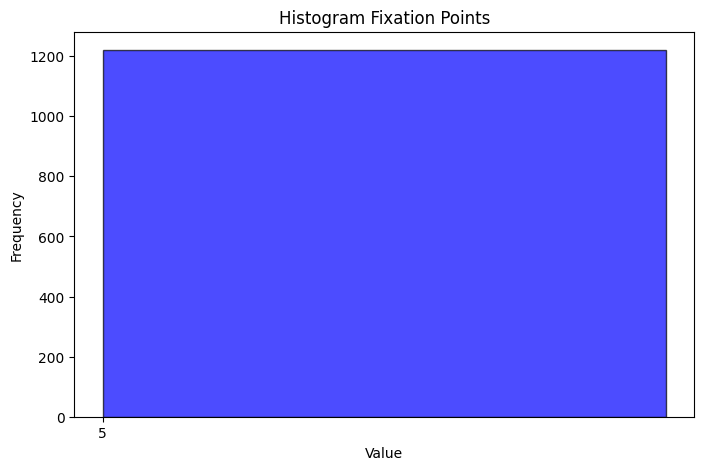

['cat_2010_000675.jpg', 'cat_2010_001534.jpg', 'cat_2009_004721.jpg', 'cat_2009_001117.jpg', 'cat_2010_002137.jpg', 'cat_2009_002628.jpg', 'cat_2010_002348.jpg', 'cat_2009_004887.jpg', 'cat_2010_000661.jpg', 'cat_2010_001177.jpg', 'cat_2010_002900.jpg', 'cat_2009_004434.jpg', 'boat_2009_003080.jpg', 'horse_2009_003734.jpg', 'boat_2010_002546.jpg', 'cat_2009_001502.jpg', 'horse_2008_007392.jpg', 'cat_2009_004248.jpg', 'cat_2009_001008.jpg', 'cat_2009_000964.jpg', 'cat_2010_001656.jpg', 'aeroplane_2010_004063.jpg', 'aeroplane_2010_001413.jpg', 'aeroplane_2008_006213.jpg', 'aeroplane_2008_004704.jpg', 'aeroplane_2010_003716.jpg', 'aeroplane_2010_004938.jpg', 'aeroplane_2008_000716.jpg', 'aeroplane_2008_007357.jpg', 'aeroplane_2009_000205.jpg', 'aeroplane_2009_001390.jpg', 'aeroplane_2009_002448.jpg', 'aeroplane_2009_004409.jpg', 'aeroplane_2008_008263.jpg', 'aeroplane_2010_000885.jpg', 'aeroplane_2009_003696.jpg', 'aeroplane_2009_002320.jpg', 'aeroplane_2010_002147.jpg', 'motorbike_2008_0

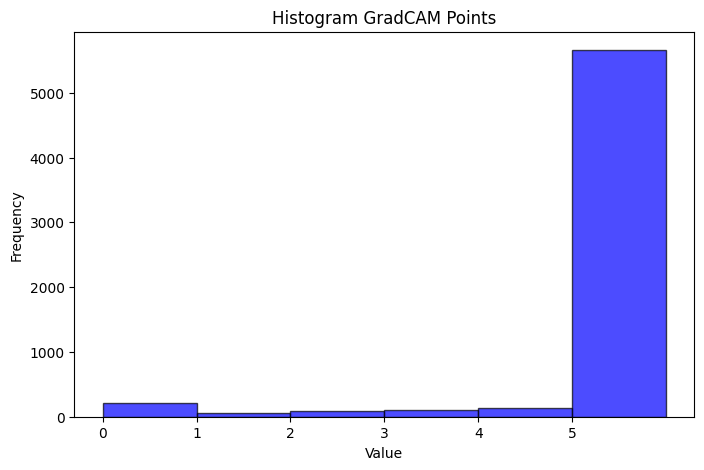

['dog_2010_003742.jpg', 'motorbike_2009_000223.jpg', 'motorbike_2008_005433.jpg', 'diningtable_2011_000731.jpg', 'diningtable_2010_004467.jpg', 'diningtable_2009_003759.jpg', 'diningtable_2008_004293.jpg', 'horse_2008_007531.jpg', 'dog_2010_001659.jpg', 'boat_2009_002205.jpg', 'boat_2011_001161.jpg', 'boat_2011_000683.jpg', 'boat_2008_001575.jpg', 'aeroplane_2011_001872.jpg', 'bicycle_2008_007470.jpg', 'bicycle_2010_001312.jpg', 'aeroplane_2008_008546.jpg', 'aeroplane_2008_007409.jpg', 'horse_2010_002482.jpg', 'sofa_2009_002681.jpg', 'sofa_2010_001586.jpg', 'horse_2008_008296.jpg', 'horse_2008_000403.jpg', 'sofa_2008_002092.jpg', 'horse_2010_003645.jpg', 'horse_2011_000771.jpg', 'horse_2011_002730.jpg', 'dog_2008_002036.jpg', 'motorbike_2008_004036.jpg', 'motorbike_2009_000726.jpg', 'motorbike_2009_003560.jpg', 'motorbike_2011_002495.jpg', 'motorbike_2008_000237.jpg', 'motorbike_2010_005620.jpg', 'motorbike_2008_002179.jpg', 'dog_2010_004204.jpg', 'dog_2010_004345.jpg', 'dog_2010_00447

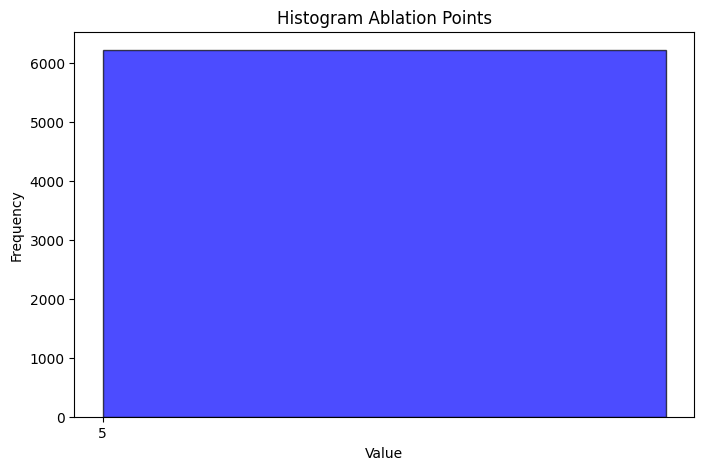

[]


In [ ]:
fix_dict_path = 'point_dict_fixation.json'
fix_dict = read_point_dictionariy(fix_dict_path)
get_random_ex(fix_dict)

fcn_resnet_dict_path = 'gradcam_points.json'
fcn_resnet_dict = read_point_dictionariy(fcn_resnet_dict_path)
fcn_resnet_dict = convert_dict_to_list(fcn_resnet_dict)
get_random_ex(fcn_resnet_dict)

faster_rcnn_dict_path = 'ablation_points.json'
faster_rcnn_dict = read_point_dictionariy(faster_rcnn_dict_path)
faster_rcnn_dict = convert_dict_to_list(faster_rcnn_dict)
get_random_ex(faster_rcnn_dict)


fix_dict, num_points, files_to_check = remove_empty_points_fixation(fix_dict)
show_histo(num_points, 'Fixation Points')
print(files_to_check)

fcn_resnet_dict, num_points, files_to_check = remove_empty_points(fcn_resnet_dict)
show_histo(num_points, 'GradCAM Points')
print(files_to_check)

faster_rcnn_dict, num_points, files_to_check = remove_empty_points(faster_rcnn_dict)
show_histo(num_points, 'Ablation Points')
print(files_to_check)



In [ ]:
class_dict = {
  'sofa': [0, 192, 0],
  'aeroplane': [0, 0, 128],
  'cat': [0, 0, 64],
  'dog': [128, 0, 64],
  'boat': [128, 0, 0],
  'cow': [0, 128, 64],
  'horse': [128, 0, 192],
  'bicycle': [0, 128, 0],
  'motorbike': [128, 128, 64],
  'diningtable': [0, 128, 192]
}


def get_filenames(filename='both_right_05_AVG_gtbb.txt'):
  # Specify the path to your text file
  filenames = []
  # Read each line of the file and store the filenames in a list
  print(os.path.join(base_folder, filename))
  with open(os.path.join(base_folder, filename), 'r') as file:
    for line in file:
      filename = line.strip()
      filename = filename.split('/')[-1]
      filenames.append(filename)
  # Print the list of filenames
  return filenames


def binarize_mask(mask, object_class):
    threshold = class_dict[object_class]
    # Create a boolean mask where the condition is true
    mask_binary = np.where(np.all(mask == threshold, axis=-1), 1, 0)
    # Convert the boolean mask to 0 (False) and 1 (True)
    mask_binary = mask_binary.astype(int)
    return mask_binary


def check_point_in_mask(binary_mask, point):
    """
    Check if a point (x, y) is within the bounds of the binary mask and if it's inside the mask.
    """
    if len(point) == 2:
      x, y = point  # Unpack the point in (x, y) format
      height, width = binary_mask.shape  # Get mask dimensions
      # Check bounds
      if 0 <= x < width and 0 <= y < height:
        if binary_mask[y, x] == 1:   # Access binary mask using (row, column) = (y, x)
          return 1
      else:
          print(f"Point {point} is outside the mask bounds for shape: {binary_mask.shape}")
    return 0


def plot_points(ax, points, color, label):
  ax.scatter([point[0] for point in points], [point[1] for point in points], color=color, label=label, s=70, marker='x')


def visualize_points_mask_image(image, points_fix, points_sal, mask_image, bin_mask, filename):
  fig, axes = plt.subplots(1, 3, figsize=(10,5))
  axes[0].imshow(image)
  axes[1].imshow(mask_image)
  axes[2].imshow(bin_mask)
  plot_points(axes[0], points_fix, 'red', 'Fixation Points')
  plot_points(axes[0], points_sal, 'blue', 'Saliency Points')
  plot_points(axes[1], points_fix, 'red', 'Fixation Points')
  plot_points(axes[1], points_sal, 'blue', 'Saliency Points')
  plot_points(axes[2], points_fix, 'red', 'Fixation Points')
  plot_points(axes[2], points_sal, 'blue', 'Saliency Points')

  axes[0].scatter([0], [0], color='green', s=70, marker='x')

  axes[0].grid('off')
  axes[1].grid('off')
  axes[0].legend()
  axes[1].legend()
  plt.title(filename)
  plt.show()


def check_point_distance_to_mask(binary_mask, point, threshold=10):
    """
    Check if the distance from a point (x, y) to the nearest pixel in the binary mask (where the mask is 1)
    is below the specified threshold.
    """
    if len(point) == 2:
        x, y = point  # Unpack the point in (x, y) format
        height, width = binary_mask.shape  # Get mask dimensions

        # Ensure the point is within the bounds
        if not (0 <= x < width and 0 <= y < height):
            print(f"Point {point} is outside the mask bounds for shape: {binary_mask.shape}")
            return 0

        # Get the coordinates of all pixels where the mask is 1
        mask_coords = np.argwhere(binary_mask == 1)  # Returns (row, col) pairs

        if mask_coords.size == 0:
            print("The binary mask contains no pixels with value 1.")
            return 0

        # Compute distances from the point to all 1-valued pixels in the mask
        distances = distance.cdist([(y, x)], mask_coords, metric='euclidean')  # Distance to all (row, col)
        min_distance = distances.min()

        # Check if the minimum distance is within the threshold
        return 1 if min_distance <= threshold else 0
    return 0


def process_all_images(filename='both_right_05_AVG_gtbb.txt'):
    both_correct_filenames = get_filenames(filename=filename)
    print(len(both_correct_filenames))
    segmentation_filenames = os.listdir(os.path.join(base_folder, 'images'))
    print(len(segmentation_filenames))
    filenames = [filename for filename in segmentation_filenames if filename in both_correct_filenames]
    print(len(filenames))
    # we consider all images, and if there was an error in one of the point creation we count that as an error
    """
    for file in ['aeroplane_2008_006213.jpg', 'motorbike_2010_000076.jpg', 'bicycle_2011_002244.jpg', 'bicycle_2010_003446.jpg']: # saliency map error -> found less than 5 points
        filenames.remove(file)
    for file in ['aeroplane_2009_004626.jpg', 'horse_2008_004175.jpg']:  # no fixation points found
        filenames.remove(file)
    """
    results_fix = {}
    results_res = {}
    results_fastet = {}
    results_dict = {}
    for filename in filenames:
        # Load image and mask
        image, mask = load_image_mask(filename, parent_folder='segmentations_per_class')
        current_class = filename.split('_')[0]
        bin_mask = binarize_mask(mask, current_class)

        # Get the fixation and saliency points
        points_fix = fix_dict[filename][0]  # Fixation points in (x, y)
        points_res = fcn_resnet_dict[filename]
        if filename in faster_rcnn_dict:
          points_faster = faster_rcnn_dict[filename]
        else:
          points_faster = []

        # Validate inputs
        if not isinstance(points_fix, list):
          print(f"Error instance fixation: {type(points_fix)}")
        if not isinstance(points_res, list):
          print(f"Error instance res: {type(points_res)}")
        if not isinstance(points_faster, list):
          print(f"Error instance res: {type(points_faster)}")

        # Count res points inside ground truth mask
        res_points_in_mask = []
        for point in points_res:
            res = check_point_in_mask(bin_mask, point)
            res_points_in_mask.append(res)

        fix_points_in_mask = []
        for point in points_fix:
          res = check_point_in_mask(bin_mask, point)
          fix_points_in_mask.append(res)

        faster_points_in_mask = []
        for point in points_faster:
          res = check_point_in_mask(bin_mask, point)
          faster_points_in_mask.append(res)

        # Visualization
        results = {
                   'class': current_class,
                   'v1_fix': fix_points_in_mask[0],
                   'v2_fix': fix_points_in_mask[1],
                   'v3_fix': fix_points_in_mask[2],
                   'v4_fix': fix_points_in_mask[3],
                   'v5_fix': fix_points_in_mask[4],
                   'fix': sum(fix_points_in_mask)/5,
                   'res': sum(res_points_in_mask)/5,
                   'faster': sum(faster_points_in_mask)/5,
                   'res_best': res_points_in_mask[0] if res_points_in_mask else 0,
                   'faster_best': faster_points_in_mask[0] if faster_points_in_mask else 0,
                   }

        results_dict[filename] = results
    print("Changed")
    return results_dict



def process_all_images_dist(filename='both_right_05_AVG_gtbb.txt'):
    both_correct_filenames = get_filenames(filename=filename)
    print(len(both_correct_filenames))
    segmentation_filenames = os.listdir(os.path.join(base_folder, 'images'))
    print(len(segmentation_filenames))
    filenames = [filename for filename in segmentation_filenames if filename in both_correct_filenames]
    print(len(filenames))
    # we consider all images, and if there was an error in one of the point creation we count that as an error
    """
    for file in ['aeroplane_2008_006213.jpg', 'motorbike_2010_000076.jpg', 'bicycle_2011_002244.jpg', 'bicycle_2010_003446.jpg']: # saliency map error -> found less than 5 points
        filenames.remove(file)
    for file in ['aeroplane_2009_004626.jpg', 'horse_2008_004175.jpg']:  # no fixation points found
        filenames.remove(file)
    """
    results_fix = {}
    results_res = {}
    results_fastet = {}
    results_dict = {}

    for filename in filenames:
        # Load image and mask
        image, mask = load_image_mask(filename, parent_folder='segmentations_per_class')
        current_class = filename.split('_')[0]
        bin_mask = binarize_mask(mask, current_class)

        # Get the fixation and saliency points
        points_fix = fix_dict[filename][0]  # Fixation points in (x, y)
        points_res = fcn_resnet_dict[filename]
        if filename in faster_rcnn_dict:
          points_faster = faster_rcnn_dict[filename]
        else:
          points_faster = []

        # Validate inputs
        if not isinstance(points_fix, list):
          print(f"Error instance fixation: {type(points_fix)}")
        if not isinstance(points_res, list):
          print(f"Error instance res: {type(points_res)}")
        if not isinstance(points_faster, list):
          print(f"Error instance res: {type(points_faster)}")

        # Count res points inside ground truth mask
        res_points_in_mask = []
        for point in points_res:
            res = check_point_distance_to_mask(bin_mask, point)
            res_points_in_mask.append(res)

        fix_points_in_mask = []
        for point in points_fix:
          res = check_point_distance_to_mask(bin_mask, point)
          fix_points_in_mask.append(res)

        faster_points_in_mask = []
        for point in points_faster:
          res = check_point_distance_to_mask(bin_mask, point)
          faster_points_in_mask.append(res)

        # Visualization
        results = {
                   'class': current_class,
                   'v1_fix': fix_points_in_mask[0],
                   'v2_fix': fix_points_in_mask[1],
                   'v3_fix': fix_points_in_mask[2],
                   'v4_fix': fix_points_in_mask[3],
                   'v5_fix': fix_points_in_mask[4],
                   'fix': sum(fix_points_in_mask)/5,
                   'res': sum(res_points_in_mask)/5,
                   'faster': sum(faster_points_in_mask)/5,
                   'res_best': res_points_in_mask[0] if res_points_in_mask else 0,
                   'faster_best': faster_points_in_mask[0] if faster_points_in_mask else 0
                   }

        results_dict[filename] = results

    return results_dict

# New experiments with new file list


In [ ]:
# check how many files have segmentations and were correctly detected by human and machine:
filename='both_right_05_AVG_gtbb.txt'
both_correct_filenames = get_filenames(filename)
print(f"Length correct filenames: {len(both_correct_filenames)}")
segmentation_filenames = os.listdir(os.path.join(base_folder, 'images'))
print(f"Length segmentations: {len(segmentation_filenames)}")

filenames = [filename for filename in segmentation_filenames if filename in both_correct_filenames]
print(len(filenames))

/content/drive/MyDrive/ucph/CCS3/both_right_05_AVG_gtbb.txt
Length correct filenames: 5257
Length segmentations: 1220
1033


In [ ]:
results_list = process_all_images()
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

/content/drive/MyDrive/ucph/CCS3/both_right_05_AVG_gtbb.txt
5257
1220
1033
Point [449, 248] is outside the mask bounds for shape: (500, 333)
Point [589, 519] is outside the mask bounds for shape: (335, 500)
Point [541, 216] is outside the mask bounds for shape: (375, 500)
Point [56, 400] is outside the mask bounds for shape: (375, 500)
Point [540, 190] is outside the mask bounds for shape: (333, 500)
Point [535, 284] is outside the mask bounds for shape: (333, 500)
Point [498, 114] is outside the mask bounds for shape: (500, 375)
Point [657, 406] is outside the mask bounds for shape: (375, 500)
Point [422, 350] is outside the mask bounds for shape: (333, 500)
Point [735, 434] is outside the mask bounds for shape: (375, 500)
Point [772, 322] is outside the mask bounds for shape: (375, 500)
Point [376, 425] is outside the mask bounds for shape: (500, 375)
Point [580, 247] is outside the mask bounds for shape: (500, 333)
Point [774, 11] is outside the mask bounds for shape: (333, 500)
Poi

In [ ]:
results_list = process_all_images('human_right_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

/content/drive/MyDrive/ucph/CCS3/human_right_05_AVG_gtbb.txt
168
1220
32
Point [365, 447] is outside the mask bounds for shape: (500, 334)
Changed
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	32	0.550	0.480	0.325	0.396	0.456	0.361	0.531	0.250	0.500	0.500	0.375	0.484	0.500	0.500	0.406	0.491	0.500	0.500
aeroplane	3	1.000	0.000	0.400	0.327	0.800	0.163	1.000	0.333	0.667	0.471	0.333	0.471	1.000	0.000	1.000	0.000	1.000	0.000
horse	2	0.500	0.500	0.700	0.300	0.300	0.300	0.500	0.500	0.000	0.000	0.500	0.500	0.500	0.500	0.000	0.000	0.500	0.500
cat	2	0.000	0.000	0.500	0.500	0.500	0.100	0.000	0.500	0.500	0.500	0.500	0.500	1.000	0.000	0.000	0.000	0.500	0.500
sofa	3	0.333	0.471	0.000	0.000	0.667	0.340	0.333	0.00

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
results_list = process_all_images('model_right_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

/content/drive/MyDrive/ucph/CCS3/model_right_05_AVG_gtbb.txt
685
1220
150
Point [484, 343] is outside the mask bounds for shape: (288, 352)
Point [441, 334] is outside the mask bounds for shape: (332, 500)
Point [760, 115] is outside the mask bounds for shape: (375, 500)
Point [527, 497] is outside the mask bounds for shape: (488, 500)
Point [226, 405] is outside the mask bounds for shape: (375, 500)
Point [214, 420] is outside the mask bounds for shape: (375, 500)
Point [772, 345] is outside the mask bounds for shape: (335, 500)
Changed
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	150	0.973	0.130	0.751	0.331	0.781	0.269	0.973	0.767	0.813	0.390	0.720	0.449	0.847	0.360	0.753	0.431	0.773	0.419
aerop

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
results_list = process_all_images('both_wrong_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

/content/drive/MyDrive/ucph/CCS3/both_wrong_05_AVG_gtbb.txt
21
1220
5
Changed
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	5	0.680	0.412	0.040	0.080	0.520	0.271	0.600	0.000	0.800	0.400	0.400	0.490	0.400	0.490	0.400	0.490	0.600	0.490
aeroplane	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
horse	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
cat	3	0.667	0.471	0.067	0.094	0.667	0.094	0.667	0.000	1.000	0.000	0.667	0.471	0.667	0.471	0.333	0.471	0.667	0.471
sofa	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
cow	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
motorbike	1	0.400	0.000	0.000	0.000	0.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## allow distant matches as well

In [28]:
results_list = process_all_images_dist()
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

/content/drive/MyDrive/ucph/CCS3/both_right_05_AVG_gtbb.txt
5257
1220
1033
Point [449, 248] is outside the mask bounds for shape: (500, 333)
Point [589, 519] is outside the mask bounds for shape: (335, 500)
Point [541, 216] is outside the mask bounds for shape: (375, 500)
Point [56, 400] is outside the mask bounds for shape: (375, 500)
Point [540, 190] is outside the mask bounds for shape: (333, 500)
Point [535, 284] is outside the mask bounds for shape: (333, 500)
Point [498, 114] is outside the mask bounds for shape: (500, 375)
Point [657, 406] is outside the mask bounds for shape: (375, 500)
Point [422, 350] is outside the mask bounds for shape: (333, 500)
Point [735, 434] is outside the mask bounds for shape: (375, 500)
Point [772, 322] is outside the mask bounds for shape: (375, 500)
Point [376, 425] is outside the mask bounds for shape: (500, 375)
Point [580, 247] is outside the mask bounds for shape: (500, 333)
Point [774, 11] is outside the mask bounds for shape: (333, 500)
Poi

In [29]:
results_list = process_all_images_dist('human_right_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)


/content/drive/MyDrive/ucph/CCS3/human_right_05_AVG_gtbb.txt
168
1220
32
Point [365, 447] is outside the mask bounds for shape: (500, 334)
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	32	0.619	0.462	0.400	0.424	0.650	0.308	0.656	0.344	0.688	0.464	0.594	0.491	0.656	0.475	0.562	0.496	0.750	0.433
aeroplane	3	1.000	0.000	0.533	0.411	0.933	0.094	1.000	0.333	1.000	0.000	0.667	0.471	1.000	0.000	1.000	0.000	1.000	0.000
horse	2	0.500	0.500	0.700	0.300	0.600	0.200	0.500	0.500	0.500	0.500	1.000	0.000	0.500	0.500	0.000	0.000	1.000	0.000
cat	2	0.000	0.000	0.500	0.500	0.800	0.000	0.000	0.500	1.000	0.000	1.000	0.000	1.000	0.000	0.500	0.500	0.500	0.500
sofa	3	0.333	0.471	0.000	0.000	0.733	0.249	0.333	0.000	1.000	

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
results_list = process_all_images_dist('model_right_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)


/content/drive/MyDrive/ucph/CCS3/model_right_05_AVG_gtbb.txt
685
1220
150
Point [484, 343] is outside the mask bounds for shape: (288, 352)
Point [441, 334] is outside the mask bounds for shape: (332, 500)
Point [760, 115] is outside the mask bounds for shape: (375, 500)
Point [527, 497] is outside the mask bounds for shape: (488, 500)
Point [226, 405] is outside the mask bounds for shape: (375, 500)
Point [214, 420] is outside the mask bounds for shape: (375, 500)
Point [772, 345] is outside the mask bounds for shape: (335, 500)
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	150	0.979	0.116	0.805	0.305	0.871	0.217	0.973	0.820	0.900	0.300	0.807	0.395	0.887	0.317	0.887	0.317	0.873	0.333
aeroplane	0	n

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
results_list = process_all_images_dist('both_wrong_05_AVG_gtbb.txt')
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)


/content/drive/MyDrive/ucph/CCS3/both_wrong_05_AVG_gtbb.txt
21
1220
5
Split	Length	GradCAM	GradCAM_std	Ablation	Ablation_std	Fix_Mean	Fix_Std	GradCAM_Best	Ablation_Best	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	5	0.720	0.392	0.040	0.080	0.840	0.150	0.800	0.000	1.000	0.000	0.600	0.490	0.600	0.490	1.000	0.000	1.000	0.000
aeroplane	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
horse	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
cat	3	0.667	0.471	0.067	0.094	0.867	0.094	0.667	0.000	1.000	0.000	0.667	0.471	0.667	0.471	1.000	0.000	1.000	0.000
sofa	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
cow	0	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan	nan
motorbike	1	0.600	0.000	0.000	0.000	1.000	0.00

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Old experiments with old file list

In [ ]:
# check how many files have segmentations and were correctly detected by human and machine:
both_correct_filenames = get_filenames()
print(len(both_correct_filenames))
segmentation_filenames = os.listdir(os.path.join(base_folder, 'images'))
print(len(segmentation_filenames))

filenames = [filename for filename in segmentation_filenames if filename in both_correct_filenames]
print(len(filenames))

In [ ]:
results_fix, results_sal, results_fix, results_list = process_all_images()

In [ ]:
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)


Split	Length	Res_Mean	Res_Std	Sal_Mean	Sal_Std	Fix_Mean	Fix_Std	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std	Faster_Mean	Faster_Std	Res_Best	Sal_Best	Faster_Best
------------------------------------------------------------------------------------------------------------------------
All	983	0.84	0.28	0.87	0.30	0.63	0.33	0.68	0.47	0.63	0.48	0.59	0.49	0.61	0.49	0.66	0.47	0.87	0.28	0.86	0.89	0.86
motorbike	106	0.85	0.22	0.88	0.26	0.71	0.27	0.72	0.45	0.71	0.45	0.75	0.43	0.64	0.48	0.75	0.44	0.88	0.22	0.86	0.86	0.86
boat	99	0.79	0.26	0.86	0.30	0.55	0.33	0.64	0.48	0.53	0.50	0.46	0.50	0.53	0.50	0.61	0.49	0.86	0.26	0.81	0.96	0.81
aeroplane	133	0.88	0.22	0.91	0.24	0.58	0.30	0.68	0.46	0.61	0.49	0.44	0.50	0.53	0.50	0.62	0.49	0.91	0.22	0.92	0.97	0.92
cow	89	0.96	0.17	0.96	0.13	0.71	0.27	0.64	0.48	0.73	0.44	0.66	0.47	0.74	0.44	0.79	0.41	0.96	0.17	0.97	1.00	0.97
diningtable	68	0.95	0.16	0.94	0.15	0.55	0.28	0.78	0.41	0.54	0.50	0.24	0

Old results

In [ ]:
results_fix, results_sal, results_fix, results_list = process_all_images()

/content/drive/MyDrive/ucph/CCS3/both_right.txt
4869
1220
983
/content/drive/MyDrive/ucph/CCS3/both_right.txt
Point [449, 248] is outside the mask bounds for shape: (500, 333)
Point [589, 519] is outside the mask bounds for shape: (335, 500)
Point [56, 400] is outside the mask bounds for shape: (375, 500)
Point [540, 190] is outside the mask bounds for shape: (333, 500)
Point [535, 284] is outside the mask bounds for shape: (333, 500)
Point [498, 114] is outside the mask bounds for shape: (500, 375)
Point [422, 350] is outside the mask bounds for shape: (333, 500)
Point [735, 434] is outside the mask bounds for shape: (375, 500)
Point [772, 322] is outside the mask bounds for shape: (375, 500)
Point [376, 425] is outside the mask bounds for shape: (500, 375)
Point [580, 247] is outside the mask bounds for shape: (500, 333)
Point [774, 11] is outside the mask bounds for shape: (333, 500)
Point [362, 424] is outside the mask bounds for shape: (375, 500)
Point [244, 410] is outside the ma

In [ ]:
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

Split	Length	Res_Mean	Res_Std	Sal_Mean	Sal_Std	Fix_Mean	Fix_Std	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	983	0.84	0.28	0.87	0.30	0.63	0.33	0.68	0.47	0.63	0.48	0.59	0.49	0.61	0.49	0.66	0.47
cat	115	0.99	0.10	0.99	0.08	0.87	0.21	0.90	0.31	0.83	0.38	0.94	0.24	0.86	0.35	0.85	0.35
cow	89	0.96	0.17	0.96	0.13	0.71	0.27	0.64	0.48	0.73	0.44	0.66	0.47	0.74	0.44	0.79	0.41
sofa	62	0.95	0.13	0.97	0.14	0.57	0.33	0.76	0.43	0.55	0.50	0.37	0.48	0.58	0.49	0.58	0.49
diningtable	68	0.95	0.16	0.94	0.15	0.55	0.28	0.78	0.41	0.54	0.50	0.24	0.42	0.59	0.49	0.59	0.49
boat	99	0.79	0.26	0.86	0.30	0.55	0.33	0.64	0.48	0.53	0.50	0.46	0.50	0.53	0.50	0.61	0.49
dog	117	0.96	0.09	0.98	0.13	0.80	0.26	0.86	0.34	0.82	0.38	0.89	0.31	0.68	0.47	0.73	0.45
motorbike	106	0.85	0.22	0.88	0.26	0.71	0.27	0.72	0.45	0.71	0.45	0.75	0.43	0.64

# Allow points to lye close to the segmentation mask

In [ ]:
results_fix, results_sal, results_fix, results_list = process_all_images_dist()


/content/drive/MyDrive/ucph/CCS3/both_right.txt
4869
1220
983
/content/drive/MyDrive/ucph/CCS3/both_right.txt
Point [449, 248] is outside the mask bounds for shape: (500, 333)
Point [589, 519] is outside the mask bounds for shape: (335, 500)
Point [56, 400] is outside the mask bounds for shape: (375, 500)
Point [540, 190] is outside the mask bounds for shape: (333, 500)
Point [535, 284] is outside the mask bounds for shape: (333, 500)
Point [498, 114] is outside the mask bounds for shape: (500, 375)
Point [422, 350] is outside the mask bounds for shape: (333, 500)
Point [735, 434] is outside the mask bounds for shape: (375, 500)
Point [772, 322] is outside the mask bounds for shape: (375, 500)
Point [376, 425] is outside the mask bounds for shape: (500, 375)
Point [580, 247] is outside the mask bounds for shape: (500, 333)
Point [774, 11] is outside the mask bounds for shape: (333, 500)
Point [362, 424] is outside the mask bounds for shape: (375, 500)
Point [244, 410] is outside the ma

In [ ]:
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

Split	Length	Res_Mean	Res_Std	Sal_Mean	Sal_Std	Fix_Mean	Fix_Std	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std	Faster_Mean	Faster_Std	Res_Best	Sal_Best	Faster_Best
------------------------------------------------------------------------------------------------------------------------
All	983	0.93	0.16	0.95	0.18	0.80	0.24	0.83	0.38	0.79	0.40	0.75	0.43	0.77	0.42	0.85	0.36	0.95	0.16	0.96	0.98	0.96
motorbike	106	0.94	0.15	0.96	0.17	0.85	0.20	0.81	0.39	0.83	0.38	0.92	0.28	0.80	0.40	0.89	0.32	0.96	0.15	0.98	0.99	0.98
boat	99	0.85	0.19	0.93	0.25	0.74	0.28	0.85	0.36	0.73	0.45	0.60	0.49	0.68	0.47	0.84	0.37	0.93	0.19	0.92	1.00	0.92
aeroplane	133	0.92	0.17	0.96	0.19	0.78	0.24	0.83	0.37	0.78	0.41	0.68	0.47	0.77	0.42	0.83	0.38	0.96	0.17	0.96	0.99	0.96
cow	89	0.97	0.16	0.96	0.13	0.86	0.20	0.79	0.41	0.90	0.30	0.80	0.40	0.92	0.27	0.90	0.30	0.96	0.16	0.97	1.00	0.97
diningtable	68	0.96	0.13	0.95	0.12	0.65	0.26	0.91	0.28	0.62	0.49	0.32	0

In [ ]:
df = pd.DataFrame.from_dict(results_list, orient='index')
print_res(df)

Split	Length	Res_Mean	Res_Std	Sal_Mean	Sal_Std	Fix_Mean	Fix_Std	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	983	0.93	0.16	0.95	0.18	0.80	0.24	0.83	0.38	0.79	0.40	0.75	0.43	0.77	0.42	0.85	0.36
cat	115	0.99	0.10	0.99	0.07	0.93	0.14	0.96	0.20	0.90	0.31	0.96	0.20	0.90	0.31	0.93	0.25
cow	89	0.97	0.16	0.96	0.13	0.86	0.20	0.79	0.41	0.90	0.30	0.80	0.40	0.92	0.27	0.90	0.30
sofa	62	0.95	0.13	0.97	0.14	0.65	0.32	0.84	0.37	0.58	0.49	0.42	0.49	0.71	0.45	0.68	0.47
diningtable	68	0.96	0.13	0.95	0.12	0.65	0.26	0.91	0.28	0.62	0.49	0.32	0.47	0.72	0.45	0.69	0.46
boat	99	0.85	0.19	0.93	0.25	0.74	0.28	0.85	0.36	0.73	0.45	0.60	0.49	0.68	0.47	0.84	0.37
dog	117	0.97	0.08	0.99	0.12	0.89	0.18	0.93	0.25	0.91	0.28	0.95	0.22	0.80	0.40	0.87	0.33
motorbike	106	0.94	0.15	0.96	0.17	0.85	0.20	0.81	0.39	0.83	0.38	0.92	0.28	0.80

# Results first try, not including images where some viewer have no fixation points

Point [449, 248] is outside the mask bounds for shape: (500, 333)
Error for fix points: None, [449, 248]


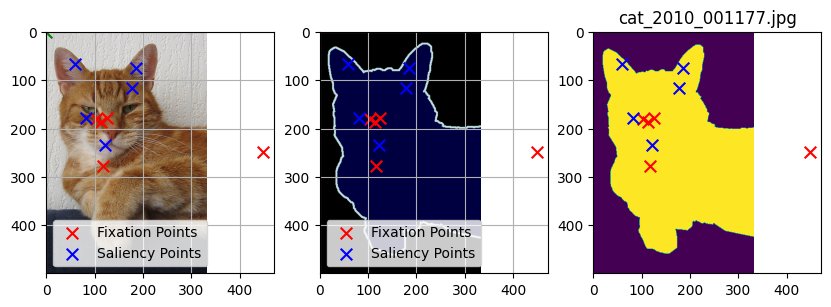

Point [589, 519] is outside the mask bounds for shape: (335, 500)
Error for fix points: None, [589, 519]


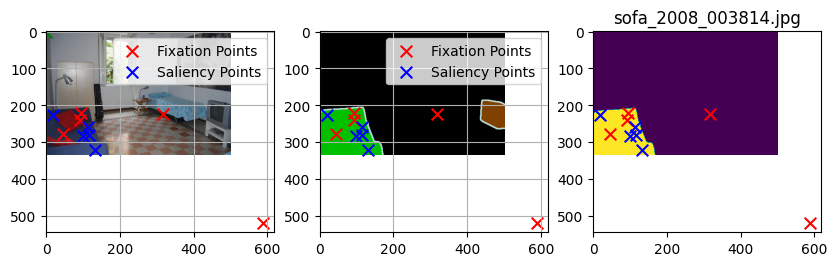

Point [541, 216] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [541, 216]


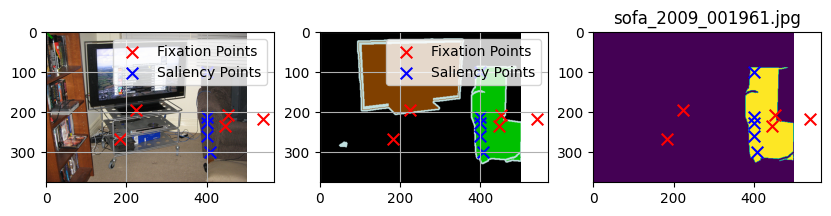

Point [56, 400] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [56, 400]


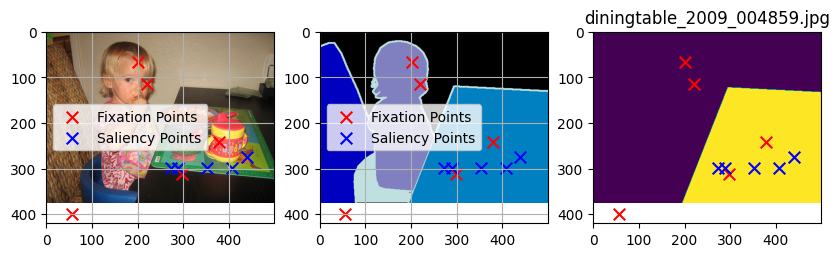

Point [484, 343] is outside the mask bounds for shape: (288, 352)
Error for fix points: None, [484, 343]


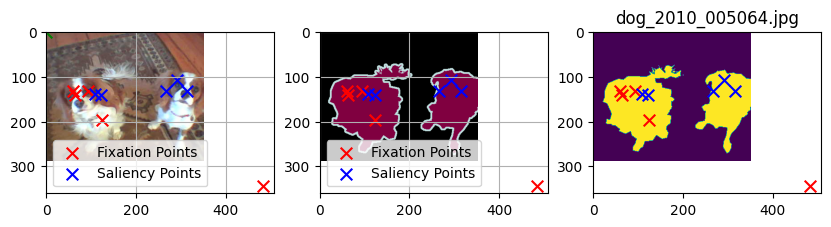

Point [540, 190] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [540, 190]


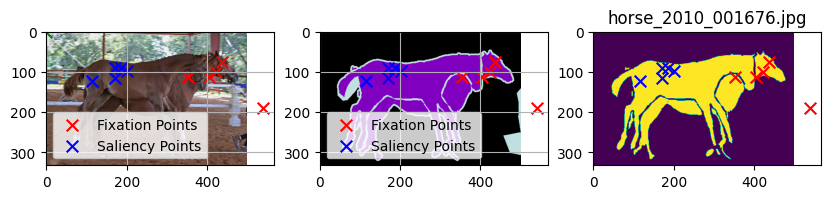

Point [535, 284] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [535, 284]


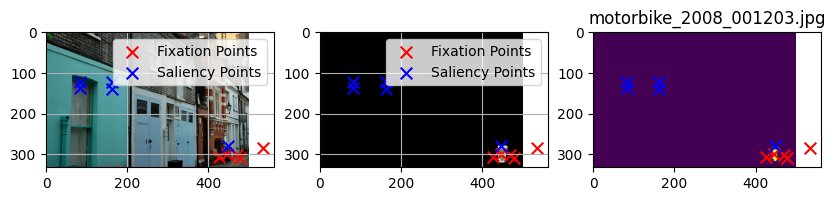

Point [498, 114] is outside the mask bounds for shape: (500, 375)
Error for fix points: None, [498, 114]


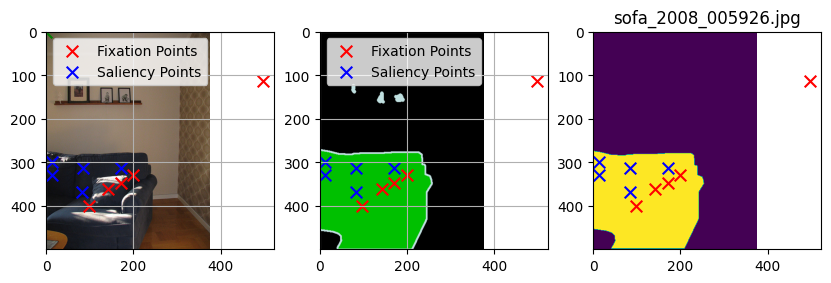

Point [657, 406] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [657, 406]


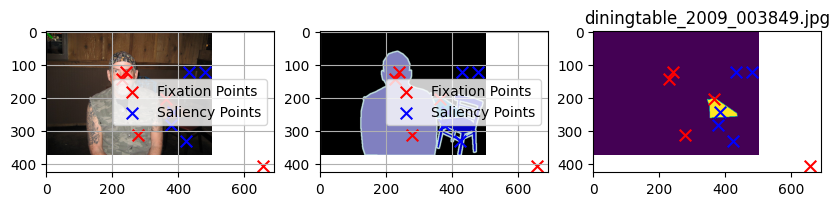

Point [422, 350] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [422, 350]


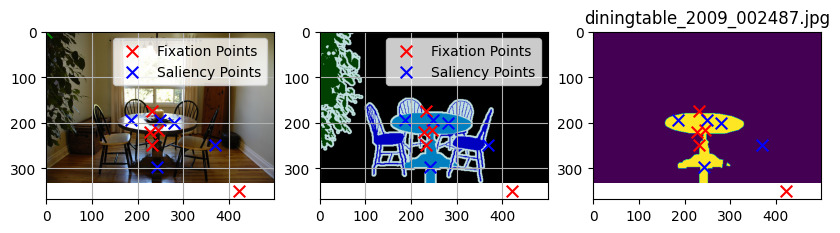

Point [441, 334] is outside the mask bounds for shape: (332, 500)
Error for fix points: None, [441, 334]


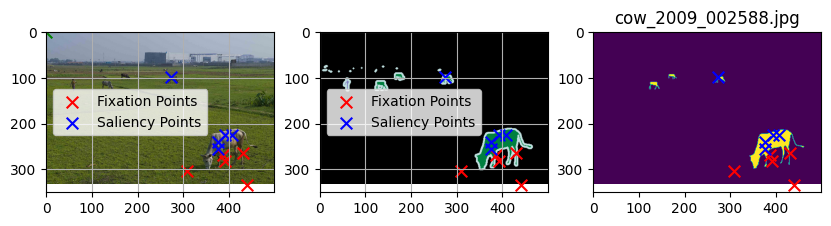

Point [735, 434] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [735, 434]


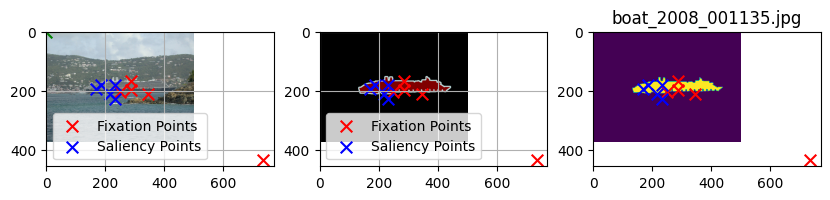

Point [772, 322] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [772, 322]


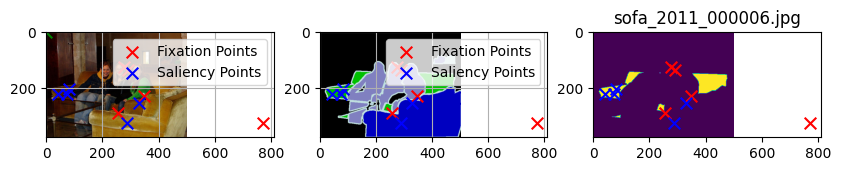

Point [376, 425] is outside the mask bounds for shape: (500, 375)
Error for fix points: None, [376, 425]


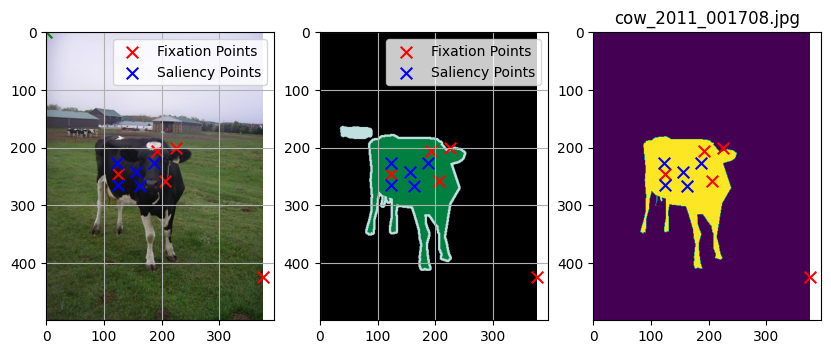

Point [760, 115] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [760, 115]


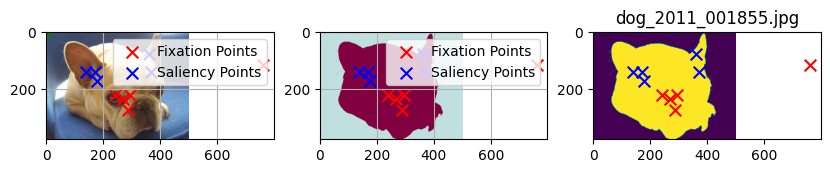

Point [580, 247] is outside the mask bounds for shape: (500, 333)
Error for fix points: None, [580, 247]


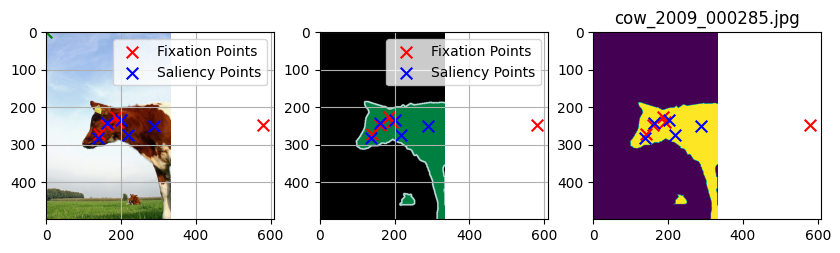

Point [774, 11] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [774, 11]


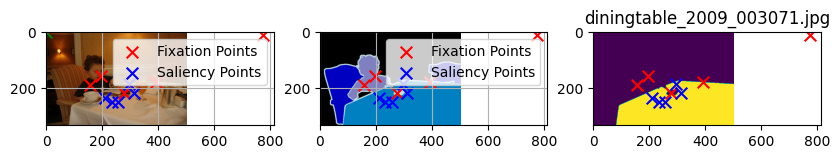

Point [527, 497] is outside the mask bounds for shape: (488, 500)
Error for fix points: None, [527, 497]


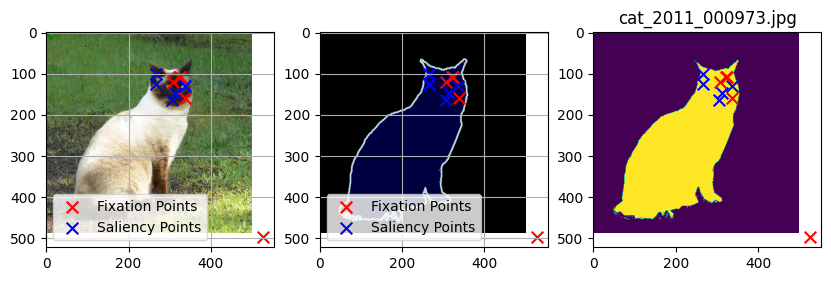

Point [362, 424] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [362, 424]


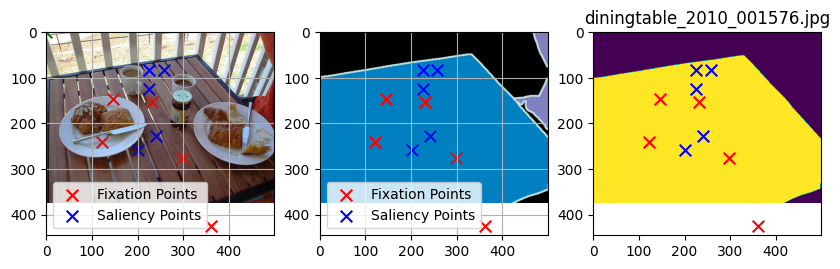

Point [244, 410] is outside the mask bounds for shape: (405, 500)
Error for fix points: None, [244, 410]


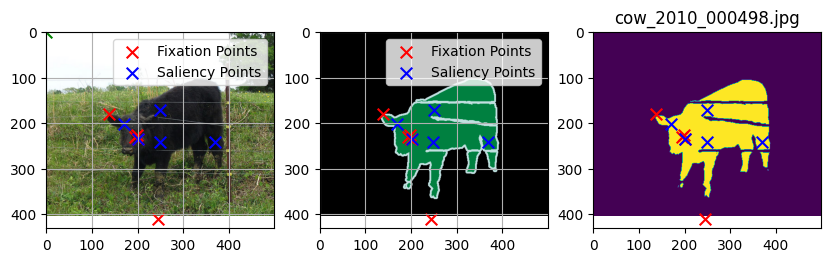

Point [664, 211] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [664, 211]


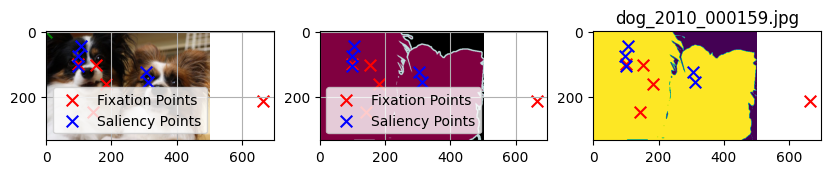

Point [298, 541] is outside the mask bounds for shape: (335, 500)
Error for fix points: None, [298, 541]


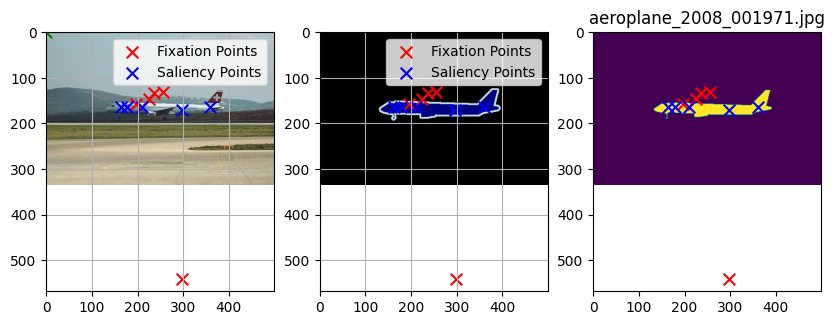

Point [500, 94] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [500, 94]


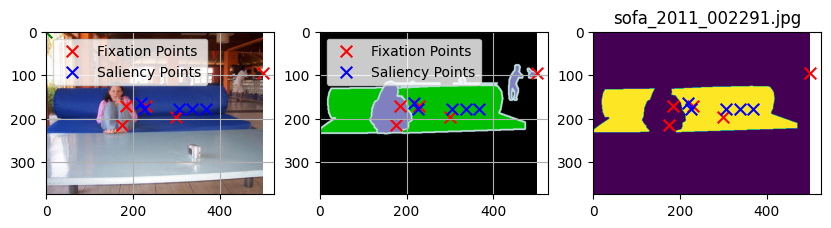

Point [3, 479] is outside the mask bounds for shape: (376, 500)
Error for fix points: None, [3, 479]


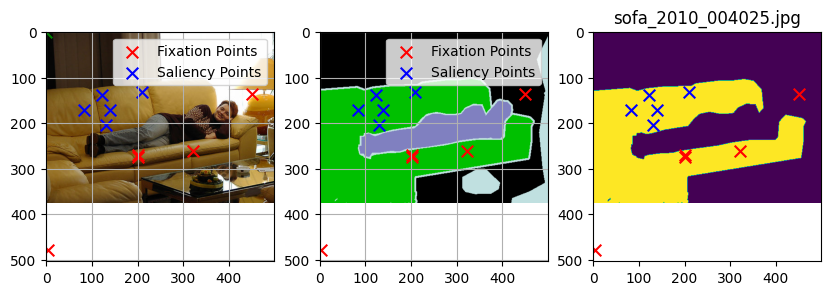

Point [456, 212] is outside the mask bounds for shape: (336, 448)
Error for fix points: None, [456, 212]


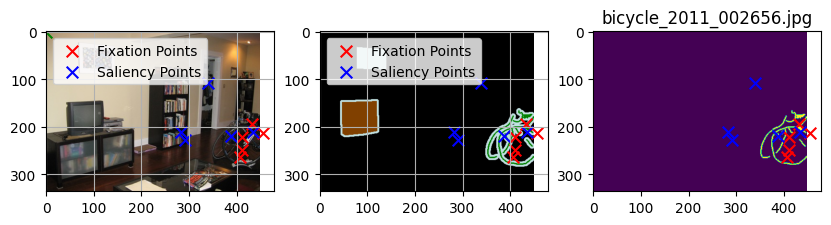

Point [608, 304] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [608, 304]


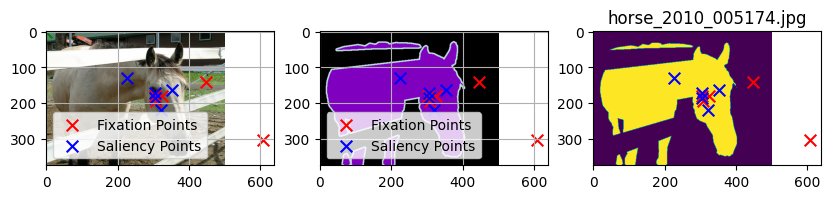

Point [226, 405] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [226, 405]


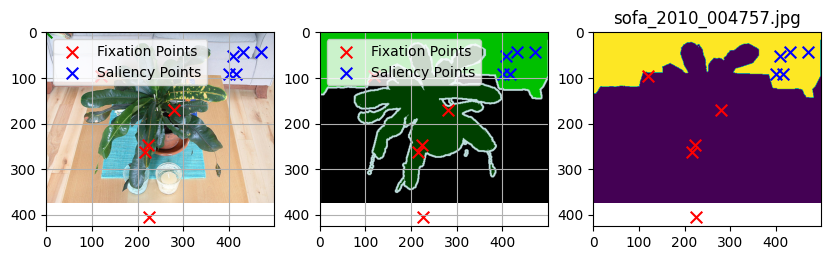

Point [287, 348] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [287, 348]


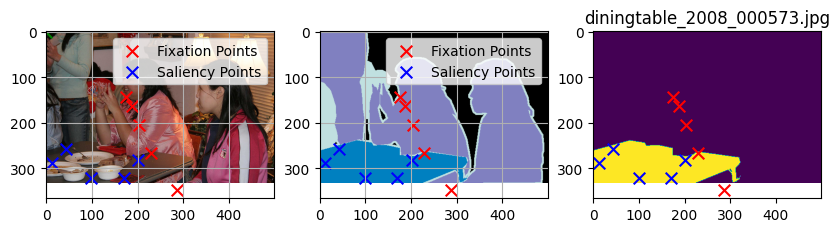

Point [214, 420] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [214, 420]


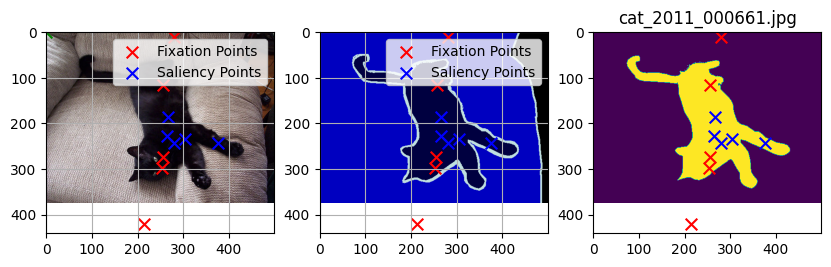

Point [772, 345] is outside the mask bounds for shape: (335, 500)
Error for fix points: None, [772, 345]


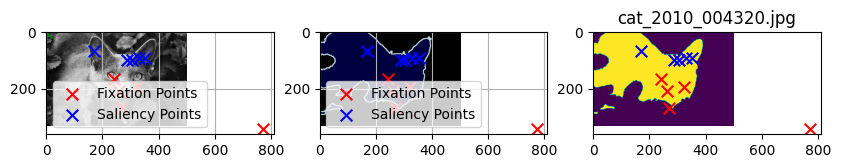

Point [303, 416] is outside the mask bounds for shape: (355, 500)
Error for fix points: None, [303, 416]


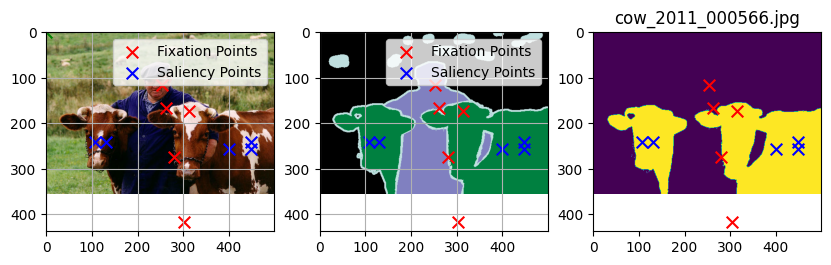

Point [550, 209] is outside the mask bounds for shape: (333, 500)
Error for fix points: None, [550, 209]


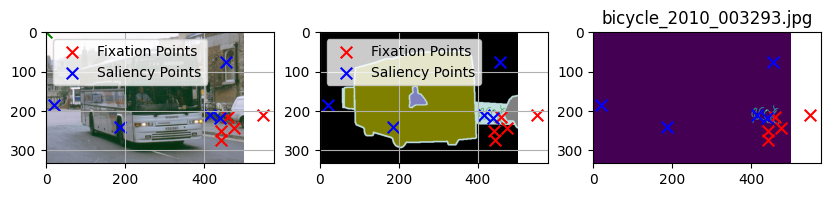

Point [301, 387] is outside the mask bounds for shape: (375, 500)
Error for fix points: None, [301, 387]


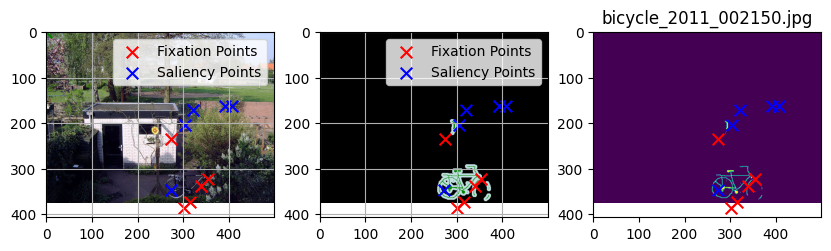

Point [365, 447] is outside the mask bounds for shape: (500, 334)
Error for fix points: None, [365, 447]


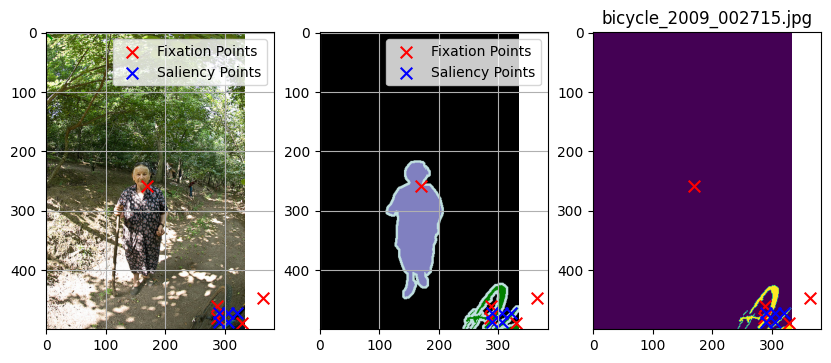

In [ ]:
#results_fix, results_sal, results_list = process_all_images()

In [ ]:
df = pd.DataFrame.from_dict(results_list, orient='index')
print(df.head)

<bound method NDFrame.head of                     class  v1_fix  v2_fix  v3_fix  v4_fix  v5_fix  fix  sal
cat_2010_000675.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
cat_2010_001534.jpg   cat     0.0     0.0     1.0     1.0     1.0  0.6  1.0
cat_2009_004721.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
cat_2009_001117.jpg   cat     1.0     0.0     1.0     1.0     0.0  0.6  1.0
cat_2009_002628.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
...                   ...     ...     ...     ...     ...     ...  ...  ...
cat_2008_001433.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
cat_2010_003230.jpg   cat     0.0     0.0     0.0     0.0     1.0  0.2  1.0
cat_2008_006325.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
cat_2008_004583.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0
cat_2008_001610.jpg   cat     1.0     1.0     1.0     1.0     1.0  1.0  1.0

[1191 rows x 8 columns]>


In [ ]:
print_res(df)

Split	Length	Sal_Mean	Sal_Std	Fix_Mean	Fix_Std	V1_Fix_Mean	V1_Fix_Std	V2_Fix_Mean	V2_Fix_Std	V3_Fix_Mean	V3_Fix_Std	V4_Fix_Mean	V4_Fix_Std	V5_Fix_Mean	V5_Fix_Std
------------------------------------------------------------------------------------------------------------------------
All	1191	0.86	0.29	0.65	0.33	0.69	0.46	0.65	0.48	0.63	0.48	0.62	0.49	0.67	0.47
diningtable	71	0.91	0.21	0.52	0.28	0.76	0.43	0.49	0.50	0.24	0.43	0.54	0.50	0.55	0.50
cat	194	0.99	0.06	0.86	0.20	0.91	0.29	0.80	0.40	0.91	0.28	0.82	0.38	0.86	0.35
motorbike	113	0.85	0.26	0.70	0.28	0.70	0.46	0.69	0.46	0.75	0.43	0.64	0.48	0.74	0.44
cow	99	0.95	0.17	0.71	0.28	0.67	0.47	0.72	0.45	0.66	0.47	0.72	0.45	0.79	0.41
boat	107	0.76	0.32	0.54	0.34	0.61	0.49	0.53	0.50	0.48	0.50	0.52	0.50	0.58	0.49
aeroplane	131	0.89	0.23	0.58	0.30	0.67	0.47	0.63	0.48	0.46	0.50	0.52	0.50	0.62	0.48
horse	102	0.96	0.11	0.64	0.31	0.56	0.50	0.64	0.48	0.59	0.49	0.68	0.47	0.73	0.45
sofa	80	0.92	0.19	0.54	0.35	0.67	0.47	0.54	0.50	0.40	0.49	0.53	0.50	0.5

Further idea:

- remove fixation point that is the furthers away
- use dilation to expand the mask and catch points that are reasonably close